In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

import re
import string
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"

In [4]:
news = pd.read_csv(train_url)

In [5]:
news.head()

,Unnamed: 0,title,text,fake
0,17366,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,5634,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,17487,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,12217,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,5535,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0


In [5]:
fake = len(news["fake"].unique())

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')


news["title"] = news["title"].apply(lambda x: ' '.join([i for i in x.split() if i not in (stopwords)]))
news["text"] = news["text"].apply(lambda x: ' '.join([i for i in x.split() if i not in (stopwords)]))

In [8]:
dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "title" : news[["title"]], 
            "text" : news[["text"]]
        }, 
     
        {
            "fake" : news[["fake"]]
        }
    )
)

In [9]:
def make_dataset(df):

  # remove stopwords
  news["title"] = news["title"].apply(lambda x: ' '.join([i for i in x.split() if i not in (stopwords)]))
  news["text"] = news["text"].apply(lambda x: ' '.join([i for i in x.split() if i not in (stopwords)]))

  # create dataset 
  dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "title" : news[["title"]], 
            "text" : news[["text"]]
        }, 
     
        {
            "fake" : news[["fake"]]
        }
    )
  )
  
  # batch dataset
  dataset.batch(100)

  return dataset
  

In [10]:
news_data = make_dataset(news)

In [11]:
# split train/validation into 80/20
training_size = int(0.80 * len(news_data))
validation_size = int(0.20 * len(news_data))

train_set = news_data.take(training_size).batch(20)
validation_set = news_data.skip(training_size).take(validation_size).batch(20)

In [43]:
# calculate base rate of model 
iterator = train_set.unbatch().map(lambda x, news_data: news_data["fake"]).as_numpy_iterator()

number = 0
for num in iterator:
  if num == 1:
    number += 1

print(number / training_size)

0.521911019544518


In [12]:
# create inputs for models 

# title is one dimension string type
title = keras.Input(
    shape = (1,), 
    name = "title",
    dtype = "string"
)

# text is 1D string type
text = keras.Input(
    shape = (1,), 
    name = "text",
    dtype = "string"
)

In [13]:
vocab_limit = 2000

# remove all punctuations + lowercase all letters
def standardization(data):
    lower = tf.strings.lower(data)
    remove_punctuation = tf.strings.regex_replace(lower, '[%s]' % re.escape(string.punctuation),'')

    return remove_punctuation 

vectorize_layer = TextVectorization(
    standardize = standardization,
    max_tokens = vocab_limit, # only consider this many words
    output_mode = 'int',
    output_sequence_length = 500) 

vectorize_layer.adapt(train_set.map(lambda x, y: x["title"]))
vectorize_layer.adapt(train_set.map(lambda x, y: x["text"]))

In [14]:
# functional API layers for 'title'
title_layer = vectorize_layer(title)
title_layer = layers.Embedding(vocab_limit, 3, name = "embedding")(title_layer)
title_layer = layers.Dropout(0.2)(title_layer)
title_layer = layers.GlobalAveragePooling1D()(title_layer)
title_layer = layers.Dropout(0.2)(title_layer)
title_layer = layers.Dense(32, activation = 'relu')(title_layer)

In [15]:
#functional API layers for 'text'
text_layer = vectorize_layer(text)
text_layer = layers.Embedding(vocab_limit, 3, name = "embedding")(text_layer)
text_layer = layers.Dropout(0.2)(text_layer)
text_layer = layers.GlobalAveragePooling1D()(text_layer)
text_layer = layers.Dropout(0.2)(text_layer)
text_layer = layers.Dense(32, activation = 'relu')(text_layer)

In [16]:
# 1st model (title only)
output = layers.Dense(fake, name = "fake")(title_layer)


In [17]:
# 1st model (title only)
model1 = keras.Model(
    inputs = [title,],
    outputs = output
)


In [38]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 title (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 500, 3)            6000      
                                                                 
 dropout (Dropout)           (None, 500, 3)            0         
                                                                 
 global_average_pooling1d (G  (None, 3)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0     

In [18]:
model1.compile(optimizer = "adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy']
)

In [25]:
history = model1.fit(train_set, 
                    validation_data = validation_set,
                    epochs = 20, 
                    verbose = False)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['text'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [23]:
# plot training vs validation history for model
def training_history(History):
  plt.plot(history.history["accuracy"], label = "training")
  plt.plot(history.history["val_accuracy"], label = "validation")
  plt.gca().set(title = "Training vs Validation Accuracy", xlabel = "Epoch", ylabel = "Accuracy")
  plt.legend()

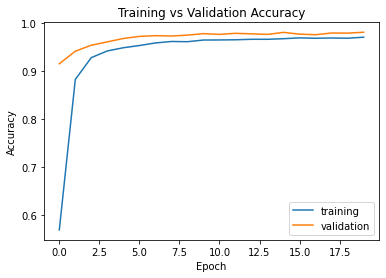

In [26]:
# model 1
training_history(history)

In [19]:
# 2nd model (text only)

output = layers.Dense(fake, name = "fake")(text_layer)

model2 = keras.Model(
    inputs = [text,],
    outputs = output
)

model2.compile(optimizer = "adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy']
)


In [20]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 500, 3)            6000      
                                                                 
 dropout_2 (Dropout)         (None, 500, 3)            0         
                                                                 
 global_average_pooling1d_1   (None, 3)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 3)                 0   

In [21]:
history = model2.fit(train_set, 
                    validation_data = validation_set,
                    epochs = 20, 
                    verbose = False)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['title'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


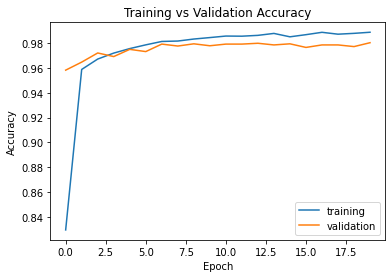

In [24]:
# model 2
training_history(history)

In [27]:
# title component for model 3 (title + text)

title_layer = vectorize_layer(title)
#title_layer = layers.Dropout(0.2)(title_layer)
#title_layer = layers.GlobalAveragePooling1D()(title_layer)
#title_layer = layers.Dropout(0.2)(title_layer)
title_layer = layers.Dense(32, activation = 'relu')(title_layer)

In [28]:
# both inputs combined
combined = layers.concatenate([title_layer, text_layer], axis = 1)

In [29]:
combined = layers.Dense(32, activation='relu')(combined)
output = layers.Dense(fake, name = "fake")(combined)

In [32]:
# model 3 (title + text)
model3 = keras.Model(
    inputs = [title, text],
    outputs = output
)

model3.compile(optimizer = "adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy']
)

In [33]:
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 text (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 500)         0           ['text[0][0]',                   
 ization)                                                         'title[0][0]']                  
                                                                                                  
 embedding (Embedding)          (None, 500, 3)       6000        ['text_vectorization[1][0]'

In [34]:
history = model3.fit(train_set, 
                    validation_data = validation_set,
                    epochs = 20, 
                    verbose = False)

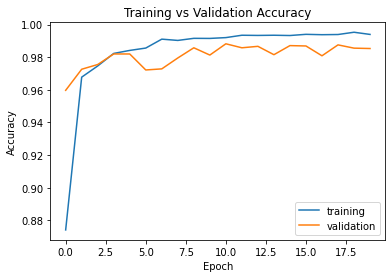

In [35]:
# model 3
training_history(history)

In [36]:
# load in test set 
test_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true"

test_set = pd.read_csv(test_url)

In [37]:
# make test set into tf dataset
test_news = make_dataset(test_set)

In [38]:
# test score using model 3
model3.evaluate(test_news)

22449/22449 [==============================] - 44s 2ms/step - loss: 0.0211 - accuracy: 0.9961


[0.021113725379109383, 0.9961245656013489]

In [39]:
# embedding visualizations (model 3)
weight = model3.get_layer('embedding').get_weights()[0] # get the weights from the embedding layer
word_list = vectorize_layer.get_vocabulary()   # get all words found in dataset     

from sklearn.decomposition import PCA
pca = PCA(n_components = 2)  # 2D PCA
weights = pca.fit_transform(weight)

# create embedded dataframe with weights
embedding_df = pd.DataFrame({
    'word' : word_list, 
    'x0'   : weights[:,0],
    'x1'   : weights[:,1]
})

In [40]:
import plotly.express as px 

# plot embedded dataframe to visualize
fig = px.scatter(embedding_df, 
                 x = "x0", 
                 y = "x1", 
                 size_max = 2,
                 hover_name = "word",
                 title = "Embedded Visualization for Fake News Classification")

fig.show()